# Using AutoEncoder as a Feature Extraction Tool

We have been using AE directly for the classifcation purposes, now we use it as a feature extraction tool.

Original post can be found [here](https://blog.myyellowroad.com/unsupervised-sentence-representation-with-deep-learning-104b90079a93).

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# from textblob import TextBlob
import numpy as np

In [2]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, accuracy_score)

In [4]:
review_df = pd.read_csv('./data/youtube-processed.csv',index_col=0)
review_df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,TEXT_LENTH,SENT_LENGTH,NOUN_RATIO,NN_COUNT,VB_COUNT,...,RB_COUNT,PR_COUNT,UNIQUE_WRDS,UNIQUE_POS,CAP_WRDS,EMO_RATIO,SELF_COUNT,PRODUCT_TITLE,matchesDf,SENTI_SCORE
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,9,9.000000,0.2727,3,2,...,1,1,1.00000,1.000000,1,0.600000,0,Psy,1,0.000000
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,32,10.666667,0.3750,12,6,...,0,3,0.90625,0.906250,7,0.222222,2,Psy,1,0.143661
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1,8,8.000000,0.2500,2,2,...,1,1,1.00000,1.000000,1,0.250000,1,Psy,1,0.000000
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,10,10.000000,0.4545,5,1,...,0,3,0.90000,0.909091,0,0.166667,3,Psy,1,0.450000
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,6,6.000000,0.3333,2,1,...,0,0,1.00000,1.000000,1,0.333333,0,Psy,1,0.000000


In [5]:
review_df.dtypes

COMMENT_ID        object
AUTHOR            object
DATE              object
CONTENT           object
CLASS              int64
TEXT_LENTH         int64
SENT_LENGTH      float64
NOUN_RATIO       float64
NN_COUNT           int64
VB_COUNT           int64
JJ_COUNT           int64
RB_COUNT           int64
PR_COUNT           int64
UNIQUE_WRDS      float64
UNIQUE_POS       float64
CAP_WRDS           int64
EMO_RATIO        float64
SELF_COUNT         int64
PRODUCT_TITLE     object
matchesDf          int64
SENTI_SCORE      float64
dtype: object

In [6]:
review_df['CLASS'].unique()

array([1, 0])

## parse sentences

In [8]:
review_text = list(review_df['CONTENT'].values)
review_text[:1]

['Huh, anyway check out this you[tube] channel: kobyoshi02']

# preprocess for keras

In [9]:
#preprocess for keras
num_words=4000
maxlen=50

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [11]:
tokenizer = Tokenizer(num_words = num_words, split=' ')

tokenizer.fit_on_texts(review_text)
seqs = tokenizer.texts_to_sequences(review_text)
pad_seqs = []
for i in seqs:
    if len(i)>4:
        pad_seqs.append(i)
pad_seqs = pad_sequences(pad_seqs,maxlen)
pad_seqs[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  944, 1857,   11,
           9,    3,    8,  591,   31, 1858],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   61,   45,   11,
           9,   10,   44,   31,    5,   92,  164,  672,    3,   14,   98,
           4, 1859,  174,    4, 1214,   26,    4,  526,  945,   24,  284,
           7,   25,   71,    5,   24,   27]], dtype=int32)

# The model

In [74]:
#The model
embed_dim = 512
latent_dim = 300
batch_size = 32

In [75]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, concatenate, GRU, RepeatVector
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from keras.models import Model, load_model
#from keras.layers import Input, Dense, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import regularizers, optimizers

In [76]:
#### Encoder Model ####
encoder_inputs = Input(shape=(maxlen,), name='Encoder-Input')
emb_layer = Embedding(num_words, embed_dim,input_length = maxlen, name='Body-Word-Embedding', mask_zero=False, trainable = True)
# Word embeding for encoder (ex: Issue Body)
x = emb_layer(encoder_inputs)
#state_h = GRU(latent_dim*2, name='Encoder-First-GRU', return_sequences=True)(x)
state_h = GRU(latent_dim, name='Encoder-Last-GRU')(x)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

In [77]:
#### Decoder Model ####
decoded = RepeatVector(maxlen)(seq2seq_encoder_out)
decoder_gru = GRU(latent_dim, return_sequences=True, name='Decoder-GRU-before')
#decoder_gru = GRU(latent_dim*2, return_sequences=True, name='Decoder-GRU-second')
decoder_gru_output = decoder_gru(decoded)
decoder_dense = Dense(num_words, activation='softmax', name='Final-Output-Dense-before')
decoder_outputs = decoder_dense(decoder_gru_output)

In [78]:
#### Seq2Seq Model ####
#seq2seq_decoder_out = decoder_model([decoder_inputs, seq2seq_encoder_out])
seq2seq_Model = Model(encoder_inputs,decoder_outputs )
seq2seq_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder-Input (InputLayer)   (None, 50)                0         
_________________________________________________________________
Encoder-Model (Model)        (None, 300)               3291700   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 50, 300)           0         
_________________________________________________________________
Decoder-GRU-before (GRU)     (None, 50, 300)           540900    
_________________________________________________________________
Final-Output-Dense-before (D (None, 50, 5000)          1505000   
Total params: 5,337,600
Trainable params: 5,337,600
Non-trainable params: 0
_________________________________________________________________


In [79]:
seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')

In [80]:
checkpointer = ModelCheckpoint(filepath="seq2seq_model-0103.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [81]:
history = seq2seq_Model.fit(pad_seqs, np.expand_dims(pad_seqs, -1),
          batch_size=batch_size,
          epochs=50,
          validation_split=0.10, 
          callbacks=[checkpointer, tensorboard, es]).history

Train on 1760 samples, validate on 196 samples
Epoch 1/50
1760/1760 [==============================] - 7s 4ms/step - loss: 3.1295 - val_loss: 3.3545
Epoch 2/50
1760/1760 [==============================] - 6s 4ms/step - loss: 2.4942 - val_loss: 3.3767
Epoch 3/50
1760/1760 [==============================] - 6s 4ms/step - loss: 2.4859 - val_loss: 3.4023
Epoch 4/50
1760/1760 [==============================] - 6s 4ms/step - loss: 2.4678 - val_loss: 3.2040
Epoch 5/50
1760/1760 [==============================] - 6s 4ms/step - loss: 2.5526 - val_loss: 3.0174
Epoch 6/50
1760/1760 [==============================] - 6s 4ms/step - loss: 2.3161 - val_loss: 2.9794
Epoch 7/50
1760/1760 [==============================] - 6s 4ms/step - loss: 2.2638 - val_loss: 2.9694
Epoch 8/50
1760/1760 [==============================] - 7s 4ms/step - loss: 2.2420 - val_loss: 2.9781
Epoch 9/50
1760/1760 [==============================] - 7s 4ms/step - loss: 2.2412 - val_loss: 2.9823
Epoch 10/50
1760/1760 [============

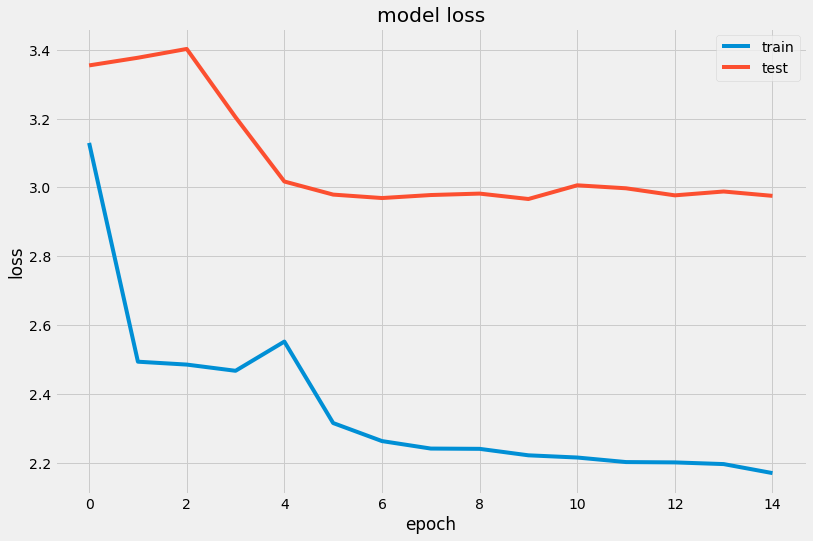

In [82]:
plt.figure(figsize=(12,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

# Feature extraction

In [84]:
#Feature extraction
contents = tokenizer.texts_to_sequences(review_df['CONTENT'].values)
contents = pad_sequences(contents,maxlen=maxlen)

x = encoder_model.predict(contents)

In [85]:
np.random.seed(2019)

msk = np.random.rand(len(review_df)) < 0.9
msk

array([False,  True,  True, ...,  True,  True,  True])

In [86]:
from sklearn.preprocessing import LabelEncoder

y = LabelEncoder().fit_transform(review_df['CLASS'].values)
y[:2]

array([1, 1])

In [87]:
X_train,y_train,X_test,y_test = x[msk],y[msk],x[~msk],y[~msk]

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
#Train the model
from sklearn.metrics import classification_report
lr = LogisticRegression().fit(X_train,y_train)
#lr.score(X_test,y_test)
y_pred = lr.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.62      0.69      0.65        89
          1       0.71      0.64      0.68       107

avg / total       0.67      0.66      0.66       196



In [90]:
lr.score(X_test, y_test)

0.6632653061224489

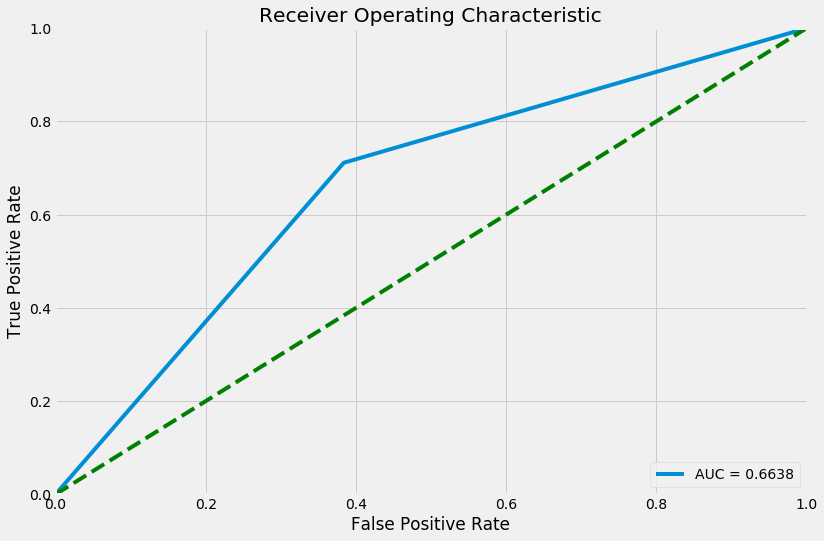

In [91]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

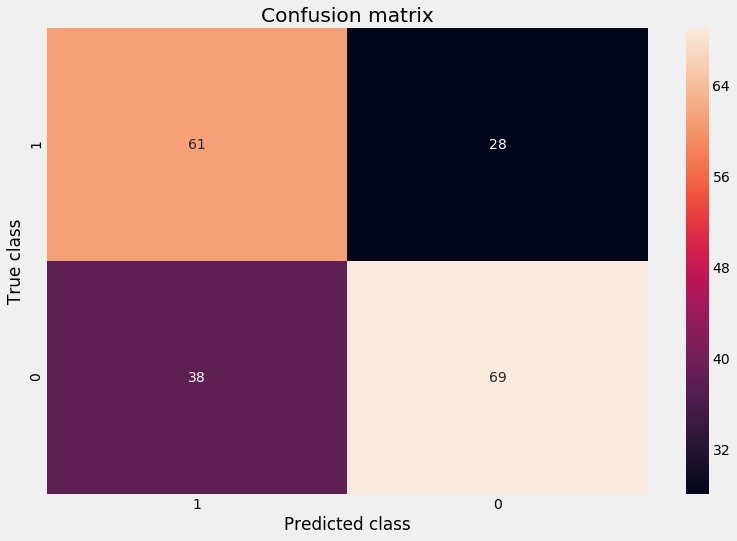

In [92]:
import seaborn as sns
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [93]:
from xgboost import XGBClassifier

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.73      0.79      0.76        89
          1       0.81      0.76      0.78       107

avg / total       0.77      0.77      0.77       196



/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [94]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.04%


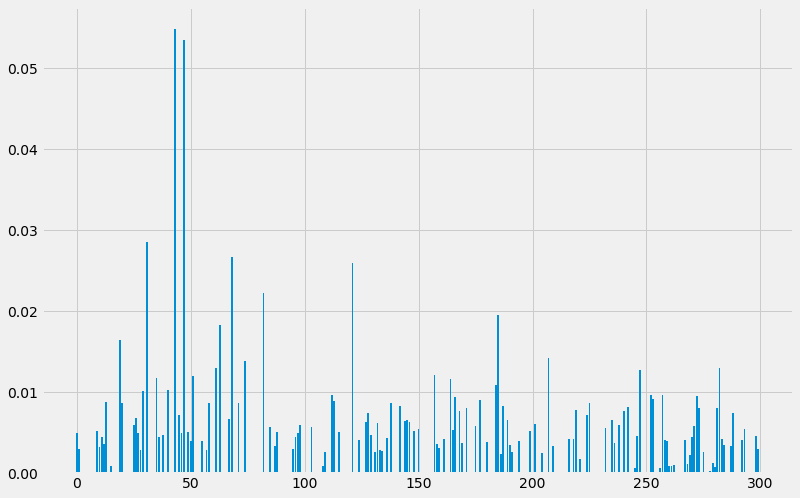

In [95]:
# print(model.feature_importances_)
# plot
plt.figure(figsize=(12, 8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

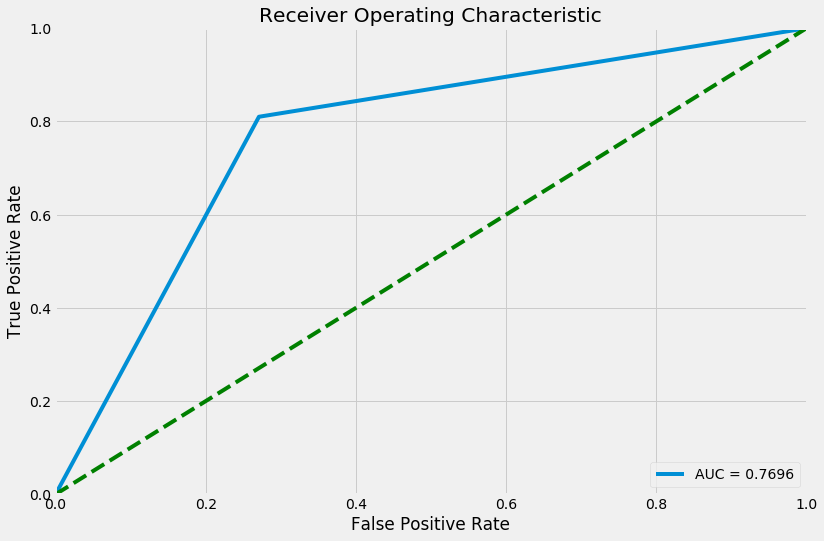

In [96]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

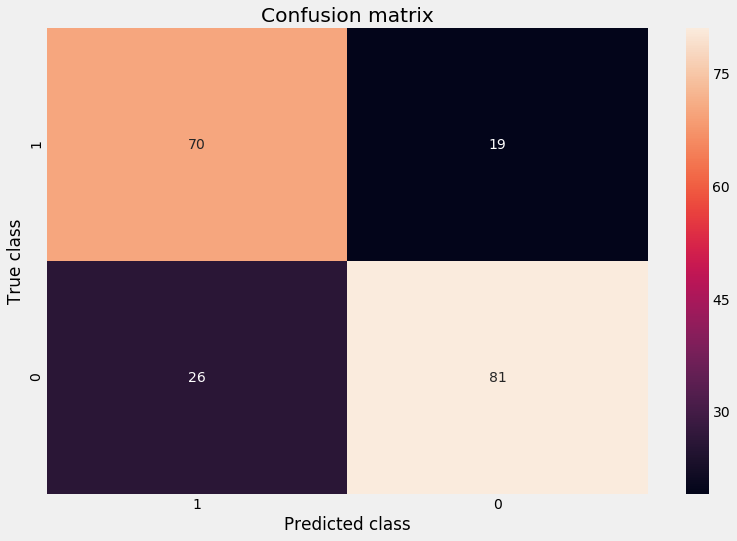

In [97]:
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Baseline Model

In [38]:
import gensim

In [39]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

In [40]:
x = np.random.rand(len(review_df), 300)
len(x)

1956

In [41]:


for i in range(len(review_df)):
    k = 0
    non = 0
    values = np.zeros(300)
    for j in review_df['CONTENT'].iloc[i].split(' '):
        if j in w2v:
            values+= w2v[j]
            k+=1
    if k > 0:
        x[i,:]=values/k
    else: 
        non+=1

In [42]:
X_train,y_train,X_test,y_test = x[msk],y[msk],x[~msk],y[~msk]

In [43]:
#Train the model
from sklearn.metrics import classification_report
lr = LogisticRegression().fit(X_train,y_train)
#lr.score(X_test,y_test)
y_pred = lr.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.88      0.85      0.87        89
          1       0.88      0.91      0.89       107

avg / total       0.88      0.88      0.88       196



In [44]:
lr.score(X_test,y_test)

0.8826530612244898

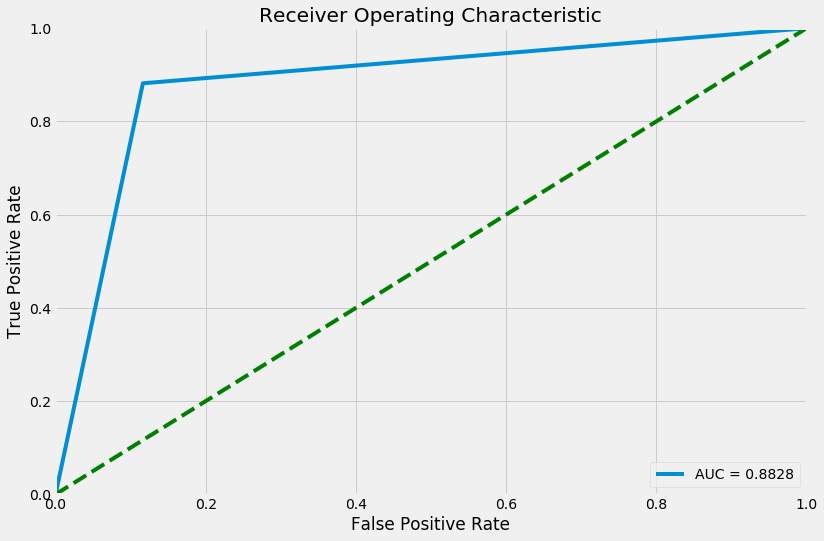

In [45]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

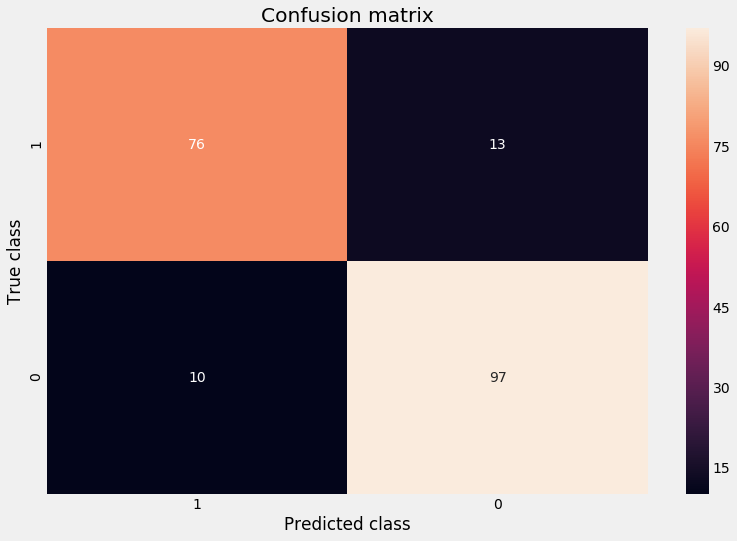

In [46]:
import seaborn as sns
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [47]:
from xgboost import XGBClassifier

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [48]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [49]:
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.86      0.88      0.87        89
          1       0.90      0.88      0.89       107

avg / total       0.88      0.88      0.88       196



In [50]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.76%


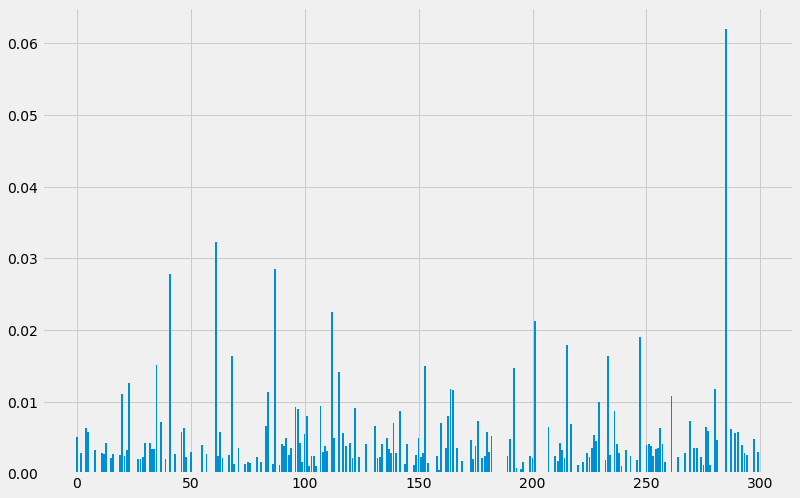

In [51]:
# print(model.feature_importances_)
# plot
plt.figure(figsize=(12, 8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

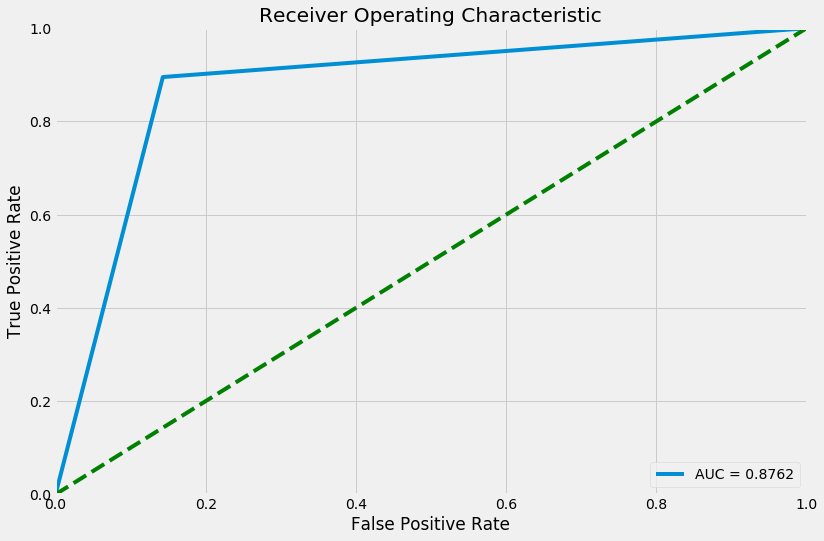

In [52]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

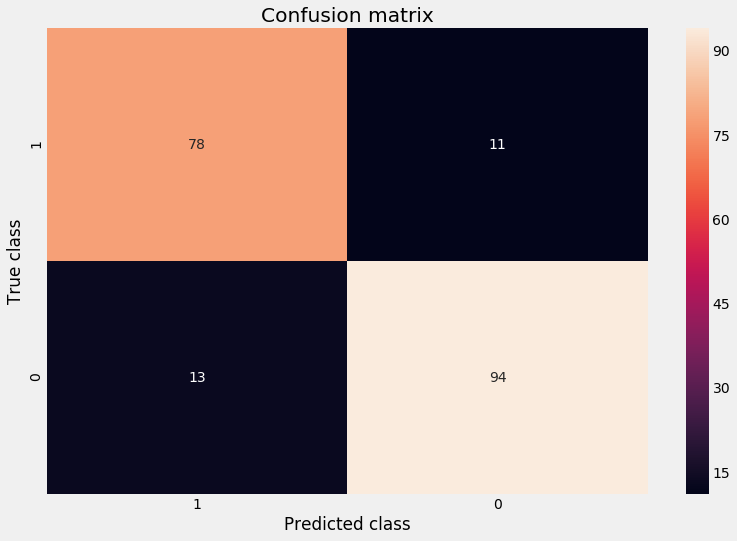

In [53]:
import seaborn as sns
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Skip-Thought Vectors

In [98]:
#Build x and y
num_words=5000
maxlen=50
tokenizer = Tokenizer(num_words = num_words, split=' ')
tokenizer.fit_on_texts(review_text)
seqs = tokenizer.texts_to_sequences(review_text)
pad_seqs = pad_sequences(seqs,maxlen)
x_skip = []
y_before = []
y_after = []

In [99]:
for i in range(1,len(seqs)-1):
    if len(seqs[i])>4:
        x_skip.append(pad_seqs[i].tolist())
        y_before.append(pad_seqs[i-1].tolist())
        y_after.append(pad_seqs[i+1].tolist())

In [100]:
x_before = np.matrix([[0]+i[:-1] for i in y_before])
x_after =np.matrix([[0]+i[:-1] for i in y_after])
x_skip = np.matrix(x_skip)
y_before = np.matrix(y_before)
y_after = np.matrix(y_after)

In [101]:
#Building the model

embed_dim = 512
latent_dim = 300
batch_size = 128

In [102]:
#### Encoder Model ####
encoder_inputs = Input(shape=(maxlen,), name='Encoder-Input')
emb_layer = Embedding(num_words, embed_dim,input_length = maxlen, name='Body-Word-Embedding', mask_zero=False)
x = emb_layer(encoder_inputs)
_, state_h = GRU(latent_dim, return_state=True, name='Encoder-Last-GRU')(x)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

In [103]:
#### Decoder Model ####
decoder_inputs_before = Input(shape=(None,), name='Decoder-Input-before')  # for teacher forcing
dec_emb_before = emb_layer(decoder_inputs_before)
decoder_gru_before = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU-before')
decoder_gru_output_before, _ = decoder_gru_before(dec_emb_before, initial_state=seq2seq_encoder_out)
decoder_dense_before = Dense(num_words, activation='softmax', name='Final-Output-Dense-before')
decoder_outputs_before = decoder_dense_before(decoder_gru_output_before)
decoder_inputs_after = Input(shape=(None,), name='Decoder-Input-after')  # for teacher forcing
dec_emb_after = emb_layer(decoder_inputs_after)
decoder_gru_after = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU-after')
decoder_gru_output_after, _ = decoder_gru_after(dec_emb_after, initial_state=seq2seq_encoder_out)
decoder_dense_after = Dense(num_words, activation='softmax', name='Final-Output-Dense-after')
decoder_outputs_after = decoder_dense_after(decoder_gru_output_after)

In [104]:
#### Seq2Seq Model ####
seq2seq_Model = Model([encoder_inputs, decoder_inputs_before,decoder_inputs_after], [decoder_outputs_before,decoder_outputs_after])
seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')
seq2seq_Model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input-before (InputLaye (None, None)         0                                            
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
Decoder-Input-after (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
Body-Word-Embedding (Embedding) (None, 50, 512)      2560000     Decoder-Input-before[0][0]       
                                                                 Decoder-Input-after[0][0]        
__________

In [105]:
history = seq2seq_Model.fit([x_skip,x_before, x_after], [np.expand_dims(y_before, -1),np.expand_dims(y_after, -1)],
          batch_size=batch_size,
          epochs=50,
          validation_split=0.10,
          callbacks=[checkpointer, tensorboard, es]).history

Train on 1427 samples, validate on 159 samples
Epoch 1/50
1427/1427 [==============================] - 4s 3ms/step - loss: 11.7932 - Final-Output-Dense-before_loss: 5.8733 - Final-Output-Dense-after_loss: 5.9199 - val_loss: 7.7687 - val_Final-Output-Dense-before_loss: 3.8872 - val_Final-Output-Dense-after_loss: 3.8814
Epoch 2/50
1427/1427 [==============================] - 3s 2ms/step - loss: 5.0452 - Final-Output-Dense-before_loss: 2.5327 - Final-Output-Dense-after_loss: 2.5125 - val_loss: 7.8240 - val_Final-Output-Dense-before_loss: 3.9178 - val_Final-Output-Dense-after_loss: 3.9061
Epoch 3/50
1427/1427 [==============================] - 3s 2ms/step - loss: 4.9725 - Final-Output-Dense-before_loss: 2.4953 - Final-Output-Dense-after_loss: 2.4773 - val_loss: 7.7101 - val_Final-Output-Dense-before_loss: 3.8865 - val_Final-Output-Dense-after_loss: 3.8236
Epoch 4/50
1427/1427 [==============================] - 3s 2ms/step - loss: 4.7785 - Final-Output-Dense-before_loss: 2.4286 - Final-Outp

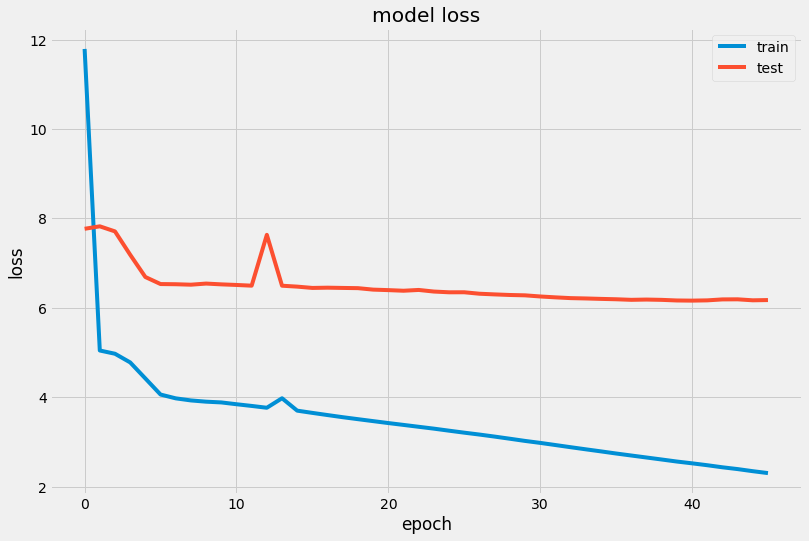

In [106]:
plt.figure(figsize=(12,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [107]:
#Feature extraction
contents = tokenizer.texts_to_sequences(review_df['CONTENT'].values)
contents = pad_sequences(contents,maxlen=maxlen)

x = encoder_model.predict(contents)

In [108]:
X_train,y_train,X_test,y_test = x[msk],y[msk],x[~msk],y[~msk]

In [109]:
#Train the model
from sklearn.metrics import classification_report
lr = LogisticRegression().fit(X_train,y_train)
#lr.score(X_test,y_test)
y_pred = lr.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.67      0.65      0.66        89
          1       0.72      0.73      0.72       107

avg / total       0.69      0.69      0.69       196



In [110]:
lr.score(X_test,y_test)

0.6938775510204082

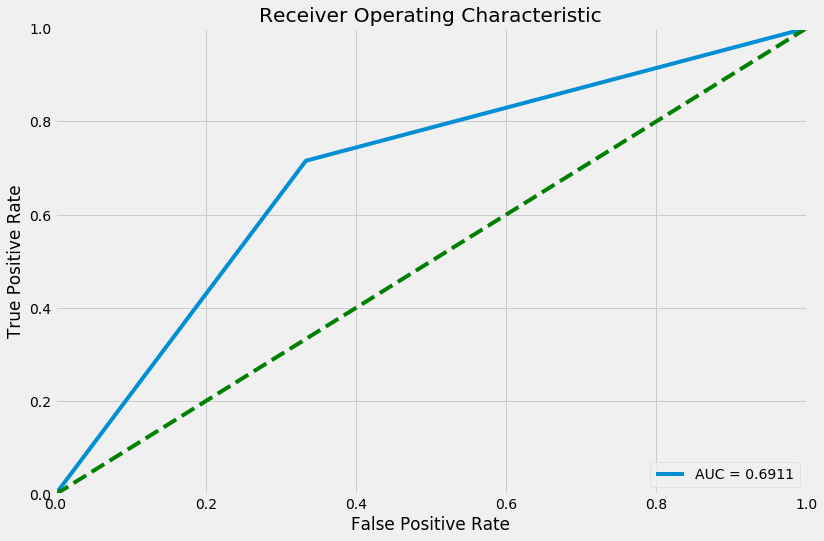

In [111]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

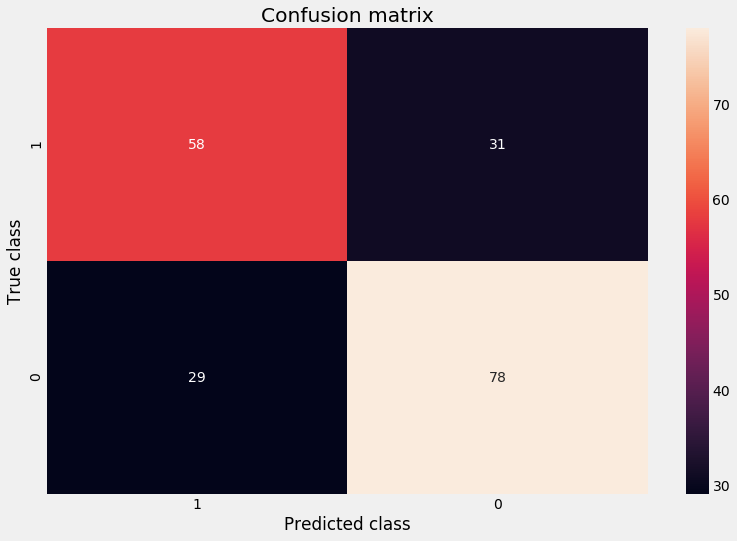

In [112]:
import seaborn as sns
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [113]:
from xgboost import XGBClassifier

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.84      0.87      0.85        89
          1       0.88      0.86      0.87       107

avg / total       0.86      0.86      0.86       196



/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [114]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.22%


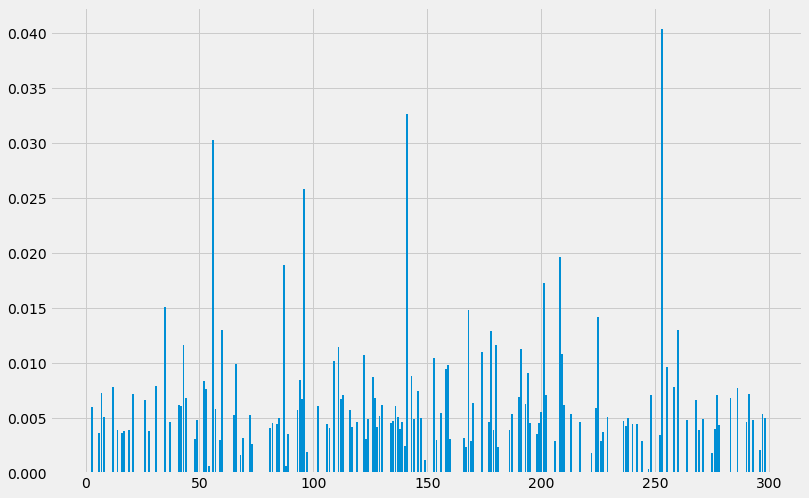

In [115]:
plt.figure(figsize=(12, 8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

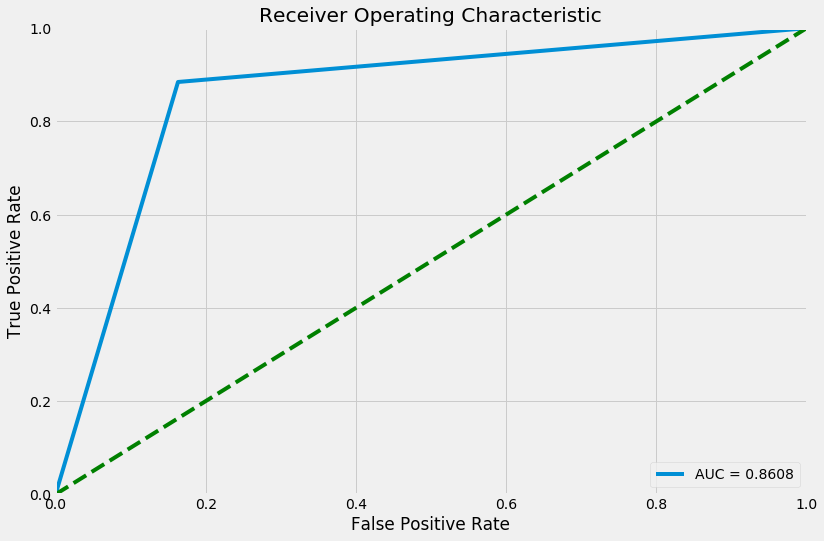

In [116]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

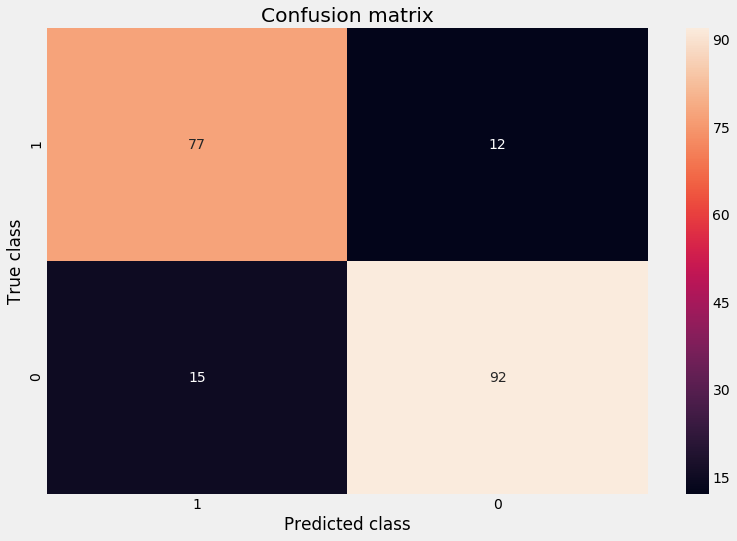

In [117]:
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()